## Proyek Klasifikasi: Prediksi Customer Churn
**Nama**: Melshita Ardia Kirana

**Email**: mc006d5x1408@student.devacademy.id

**ID Dicoding:** MC006D5X1408

**Sumber Dataset:**

Dataset yang digunakan berasal dari platform Kaggle dengan nama:
Telco Customer Churn Dataset
Link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Dataset ini berisi informasi pelanggan dari perusahaan telekomunikasi fiktif, dan sangat sering digunakan sebagai studi kasus prediksi churn dalam industri telekomunikasi.


## 1. Import Library

In [39]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preparation

In [40]:
file_path = '/content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/dataset_TelcoCust.csv'
df = pd.read_csv(file_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Preprocessing

In [41]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(['customerID'], axis=1, inplace=True, errors='ignore')
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [col for col in df.columns if col not in num_cols + ['Churn']]

df_encoded = pd.get_dummies(df, columns=cat_cols)

scaler = MinMaxScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

### 3.1 Data Splitting

In [42]:
# Split data menjadi data train dan test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran data train:", X_train.shape)
print("Ukuran data test:", X_test.shape)

Ukuran data train: (5625, 46)
Ukuran data test: (1407, 46)


## 4. Modeling

In [43]:
# Inisialisasi model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

trained_models = {}

# Training semua model
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Model {name} telah dilatih.")

Model Logistic Regression telah dilatih.
Model Random Forest telah dilatih.
Model Support Vector Machine telah dilatih.
Model XGBoost telah dilatih.
Model K-Nearest Neighbors telah dilatih.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 5. Evaluasi dan Visualisasi

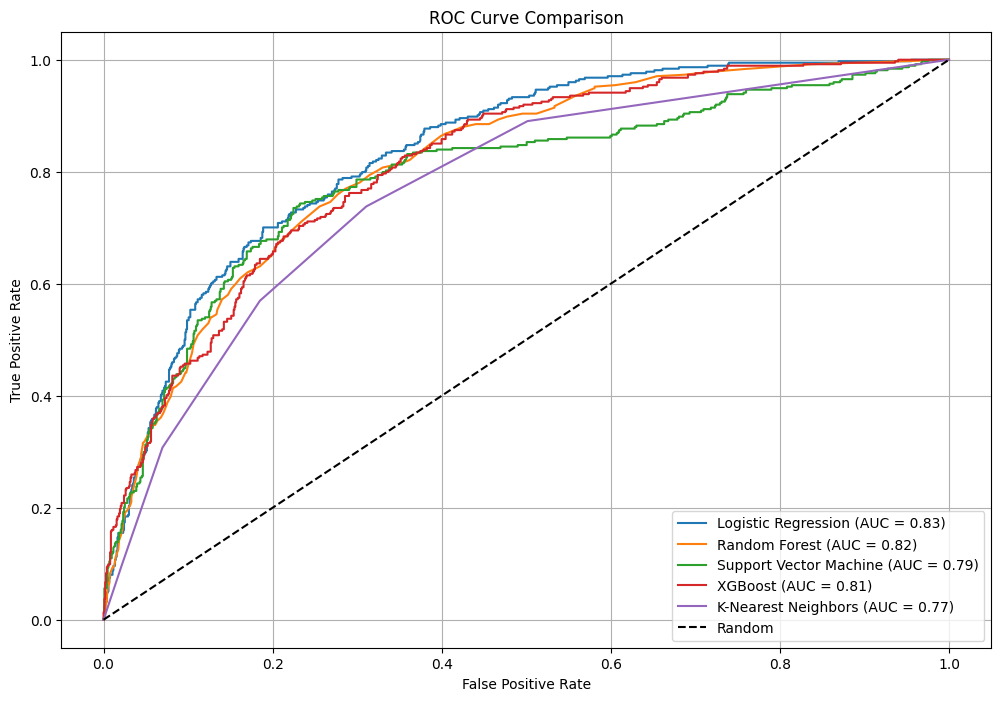


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



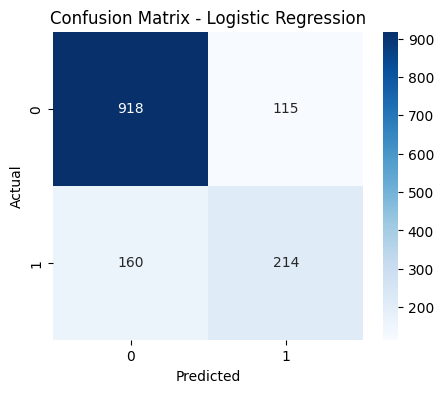


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



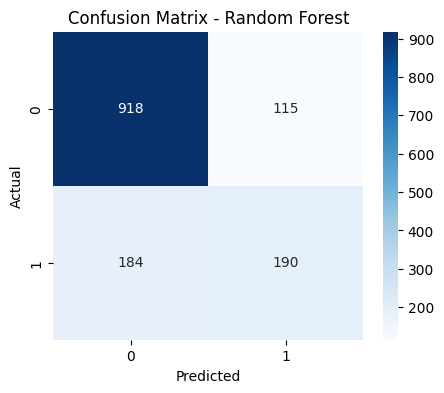


=== Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



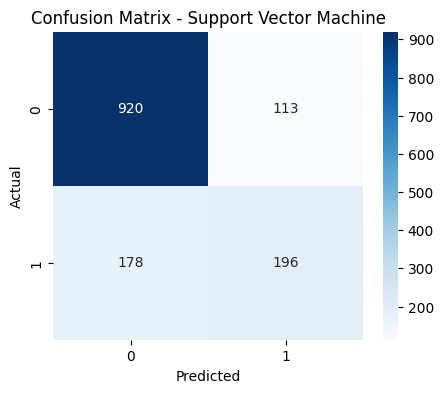


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407



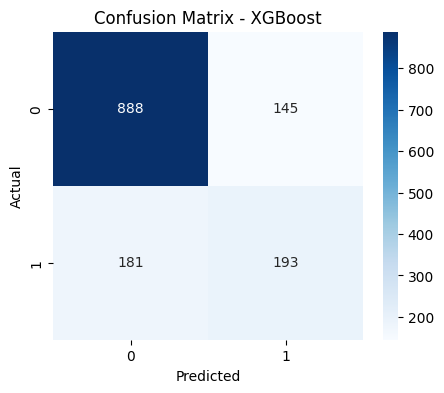


=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.53      0.57      0.55       374

    accuracy                           0.75      1407
   macro avg       0.68      0.69      0.69      1407
weighted avg       0.76      0.75      0.75      1407



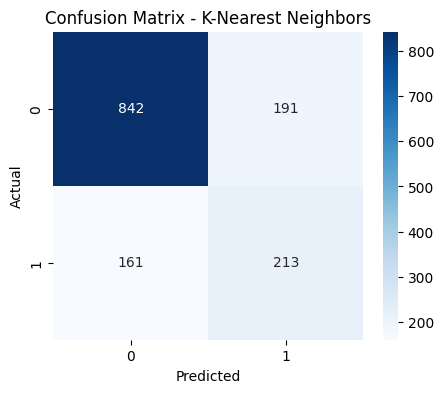

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Visualisasi ROC Curve
for name, model in trained_models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Evaluasi lebih detail
for name, model in trained_models.items():
    print(f"\n=== {name} ===")
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

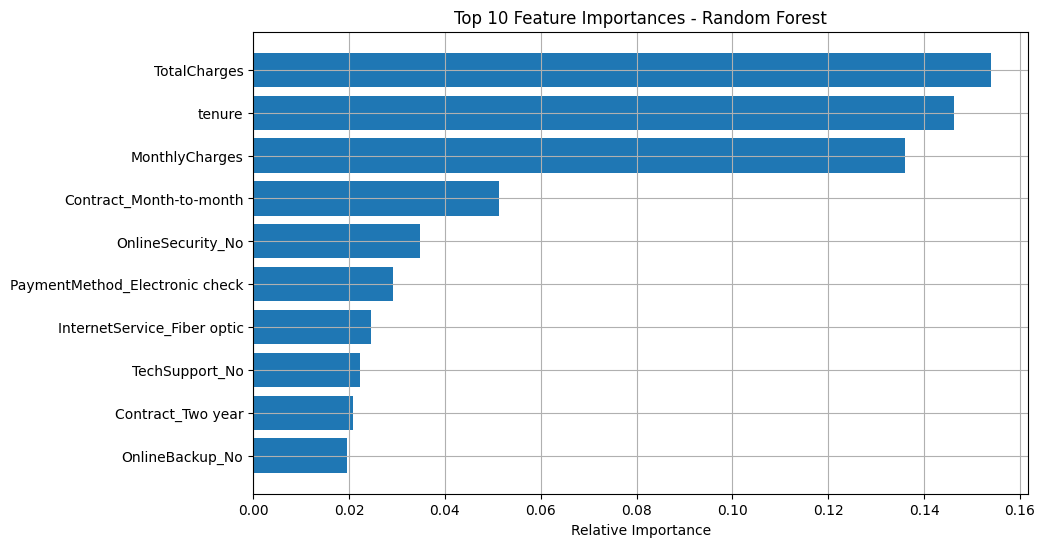

In [45]:
# Visualisasi Feature Importance dari Random Forest
importances = trained_models['Random Forest'].feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances - Random Forest")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.grid()
plt.show()

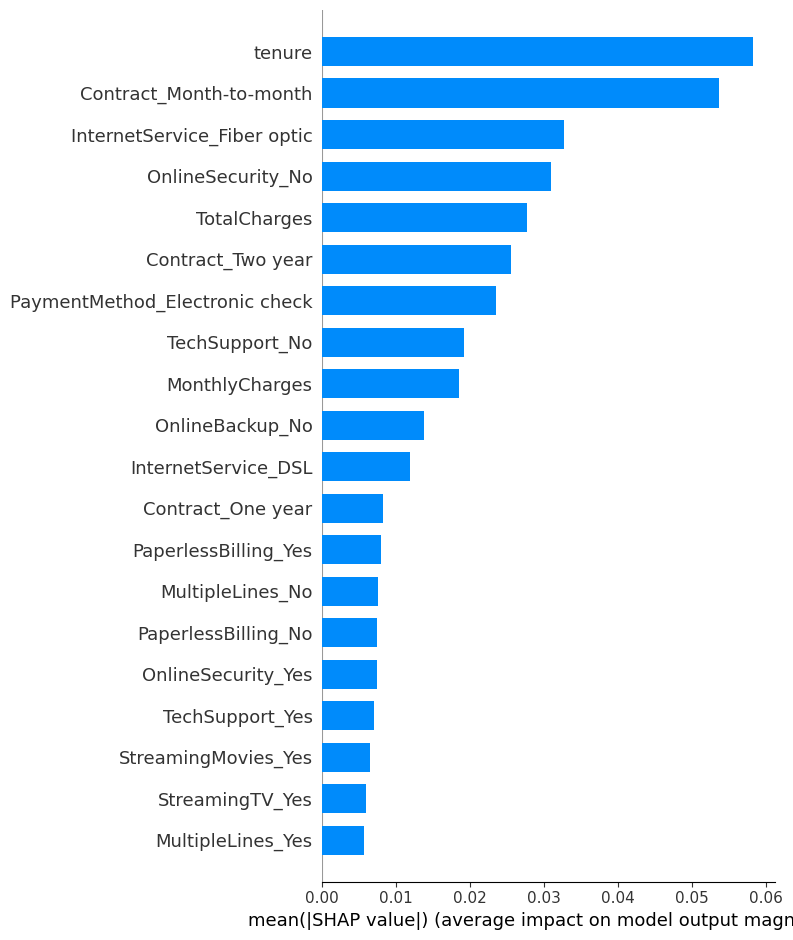

In [46]:
# SHAP Summary Plot
import shap

explainer = shap.TreeExplainer(trained_models['Random Forest'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")

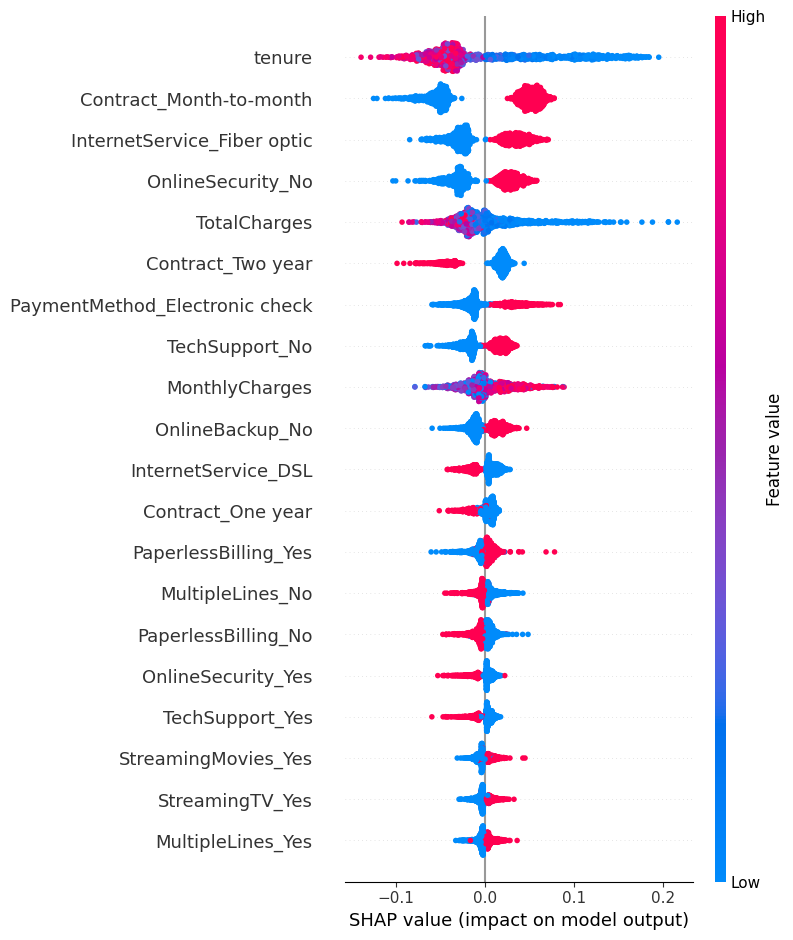

In [47]:
shap.summary_plot(shap_values[:, :, 1], X_test)

## 6. Konversi Model

In [48]:
import joblib

# Simpan model terbaik (misalnya Random Forest)
best_model = trained_models['Random Forest']
model_path = '/content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/model_churn_rf.pkl'
joblib.dump(best_model, model_path)

print(f"Model berhasil disimpan di {model_path}")

Model berhasil disimpan di /content/drive/MyDrive/Dicoding/Project Machine Learning Terapan/Proyek Pertama/model_churn_rf.pkl


## 7. Inference

In [49]:
# Load model yang telah disimpan
loaded_model = joblib.load(model_path)

# Contoh inference: Ambil 5 sample dari test set
sample = X_test.sample(5, random_state=1)
true_labels = y_test.loc[sample.index]

# Prediksi
predictions = loaded_model.predict(sample)
probs = loaded_model.predict_proba(sample)[:, 1]

# Tampilkan hasil
result_df = pd.DataFrame({
    'Predicted': predictions,
    'Probability (Churn)': probs,
    'Actual': true_labels.values
}, index=sample.index)

print("Hasil Inference:")
print(result_df)

Hasil Inference:
      Predicted  Probability (Churn)  Actual
458           0                 0.28       0
3327          0                 0.38       0
5104          0                 0.00       0
5089          0                 0.33       0
3377          0                 0.01       0
